In [11]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import cg, spilu, LinearOperator, aslinearoperator
from scipy.sparse import isspmatrix, csr_matrix, tril, diags

In [12]:
# Function to create matrix A
def generate_matrix_A(n):
    diagonals = [
        -1 * np.ones(n - 1),  # Lower diagonal
        2 * np.ones(n),       # Main diagonal
        -1 * np.ones(n - 1)   # Upper diagonal
    ]
    
    # Create the sparse matrix
    A = diags(diagonals, offsets=[-1, 0, 1], format='csr')
    
    # Adjust the last diagonal element
    A[-1, -1] = 1  # Update the last diagonal element directly in the sparse matrix
    
    return A

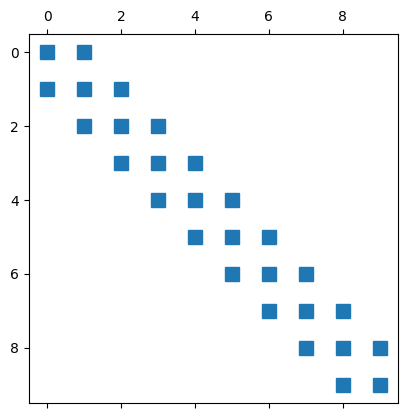

In [14]:
A= generate_matrix_A(10)
plt.spy(A, markersize=10, precision=0.1)
plt.show()

In [15]:
# Function to create vector b
def generate_vector_b(n):
    b = np.zeros(n)
    b[0] = 1
    return b

In [16]:
def conjugate_gradient_with_tracking(A, b, x0=None, tol=1e-6, max_iter=1000, verbose=False):
    if x0 is None:
        x0 = np.zeros_like(b)
    x = x0.copy()
    r = b - A @ x
    rs_old = np.dot(r.T, r)
    
    if np.sqrt(rs_old) < tol:  # Initial guess is the solution
        if verbose:
            print("Initial guess is the solution.")
        return x, [np.sqrt(rs_old)], [x], 0

    p = r.copy()
    residuals = [np.sqrt(rs_old)]
    solutions = [x.copy()]

    for i in range(max_iter):
        Ap = A @ p
        denominator = np.dot(p.T, Ap)
        if np.abs(denominator) < 1e-12:  # Prevent division by zero
            if verbose:
                print("Numerical instability detected. Terminating early.")
            break
        alpha = rs_old / denominator
        x += alpha * p
        r -= alpha * Ap
        rs_new = np.dot(r.T, r)

        residuals.append(np.sqrt(rs_new))
        solutions.append(x.copy())

        if np.sqrt(rs_new) < tol:  # Convergence check
            if verbose:
                print(f"Converged in {i + 1} iterations with residual norm {np.sqrt(rs_new):.2e}.")
            break

        p = r + (rs_new / rs_old) * p
        rs_old = rs_new

    else:
        if verbose:
            print(f"Did not converge within {max_iter} iterations. Final residual norm: {np.sqrt(rs_new):.2e}")

    return x, residuals, solutions, i + 1


In [17]:
# Main experiment
def run_experiment(n,x0=None):
    A = generate_matrix_A(n)
    b = generate_vector_b(n)
    
    
    # Solve using custom CG
    print(f"Running CG for n={n}")
    
    x_custom,residuals, solutions,iterations = conjugate_gradient_with_tracking(A, b,x0)
    #print(f"Custom Solution (n={n}): {x_custom} , Number of iterations = {iterations}")

    # Verify the solution
    x_true = np.ones(n)  # The true solution is a vector of ones
    error_custom_cg = np.linalg.norm(x_custom - x_true)
    print(f"Custom Solution (n={n}), Number of iterations = {iterations}, Custom Solution error: {error_custom_cg}")

    # List to track iterations
    iteration_count = []

    def callback(xk):
        iteration_count.append(1)
    
    # Validate with scipy's cg solver
    x_scipy, info = cg(A, b,x0, atol=1e-6,maxiter=1000, callback=callback)  # Fixed here
    error_scipy_cg = np.linalg.norm(x_scipy - x_true)
    print(f"Scipy CG Convergence Info: {info}, Number of iterations:{len(iteration_count)}, Scipy Solution error: {error_scipy_cg}")
    
    return x_custom, x_scipy


In [18]:
# Run for different matrix sizes
for n in [100]:
    # Generate random and adjusted starting points
    x0 = np.ones(n)
    x0_random = np.random.rand(n)
    x0_adjusted = np.ones(n) - x0_random

    # Run the experiment with `x0`
    x_custom_random, x_scipy_random = run_experiment(n, x0=None)
    print(f"n={n}, x0 results\n")

    # Run the experiment with `x0_one`
    x_custom_random, x_scipy_random = run_experiment(n, x0=x0)
    print(f"n={n}, x0_one results\n")
    
    # Run the experiment with `x0_random`
    x_custom_random, x_scipy_random = run_experiment(n, x0=x0_random)
    print(f"n={n}, x0_random results\n")
    
    # Run the experiment with `x0_adjusted`
    x_custom_adjusted, x_scipy_adjusted = run_experiment(n, x0=x0_adjusted)
    print(f"n={n}, x0_adjusted results")


Running CG for n=100
Custom Solution (n=100), Number of iterations = 100, Custom Solution error: 3.590468814167395e-14
Scipy CG Convergence Info: 0, Number of iterations:100, Scipy Solution error: 3.590468814167395e-14
n=100, x0 results

Running CG for n=100
Custom Solution (n=100), Number of iterations = 0, Custom Solution error: 0.0
Scipy CG Convergence Info: 0, Number of iterations:0, Scipy Solution error: 0.0
n=100, x0_one results

Running CG for n=100
Custom Solution (n=100), Number of iterations = 100, Custom Solution error: 1.6423499783431671e-12
Scipy CG Convergence Info: 0, Number of iterations:100, Scipy Solution error: 1.6423499783431671e-12
n=100, x0_random results

Running CG for n=100
Custom Solution (n=100), Number of iterations = 100, Custom Solution error: 2.7588055922248697e-12
Scipy CG Convergence Info: 0, Number of iterations:100, Scipy Solution error: 2.7588055922248697e-12
n=100, x0_adjusted results


In [19]:
def plot_results(residuals, solutions, true_solution, n):
    # Plot residual norms
    plt.figure(figsize=(10, 5))
    plt.plot(residuals, marker='o')
    plt.title(f'Residual Norms per Iteration (n={n})')
    plt.xlabel('Iteration')
    plt.ylabel('Residual Norm')
    plt.yscale('log')
    plt.grid(True)
    plt.show()
    
    # # Visualize intermediate solutions
    # plt.figure(figsize=(10, 5))
    # for i in range(len(solutions)):
    #     if i % (len(solutions) // 5) == 0 or i == len(solutions) - 1:  # Plot 5 steps + final
    #         plt.plot(solutions[i], label=f'Iteration {i}')
    # plt.plot(true_solution, label='True Solution', linestyle='**', color='black')
    # plt.title(f'Solution Evolution (n={n})')
    # plt.xlabel('Index')
    # plt.ylabel('Solution Value')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


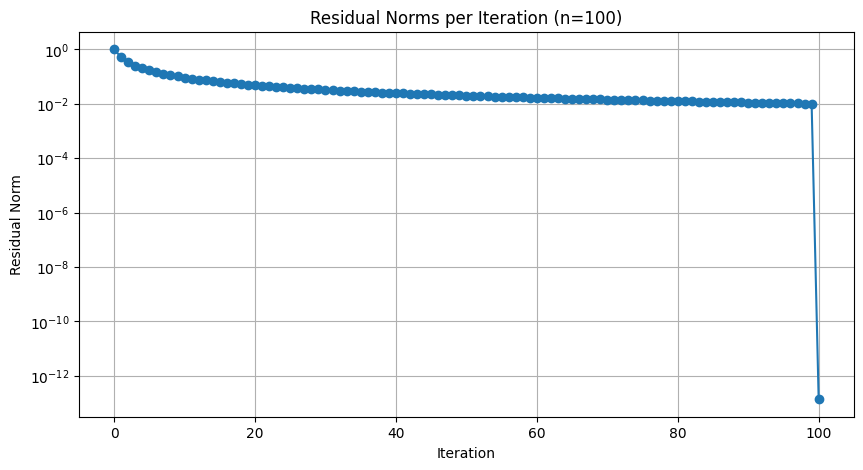

In [20]:
# Run experiment and plot for n=50
n = 100
A = generate_matrix_A(n)
b = generate_vector_b (n)

# True solution for comparison
true_solution = np.ones(n)

# Run CG with tracking
x_custom,residuals, solutions,iterations = conjugate_gradient_with_tracking(A, b)

# Plot results
plot_results(residuals, solutions, true_solution, iterations)


The plots show the following:
	1.	Residual Norms:
	•	The residual norm decreases exponentially with each iteration, evident from the straight-line behavior on the log scale. This indicates the method’s consistent convergence.
	2.	Solution Evolution:
	•	The intermediate solutions gradually approach the true solution  [1, \dots, 0] .
	•	The first few iterations adjust the values on the leftmost indices, and subsequent iterations refine the solution, spreading information to the right.

observation 3.obvservation in screen shot in note